前⼀章中我们介绍了循环神经⽹络的基础知识，这种⽹络可以更好地处理序列数据。我们在⽂本数据上实现
了基于循环神经⽹络的语⾔模型，但是对于当今各种各样的序列学习问题，这些技术可能并不够⽤。

例如，循环神经⽹络在实践中⼀个常⻅问题是数值不稳定性。尽管我们已经应⽤了梯度裁剪等技巧来缓解这
个问题，但是仍需要通过设计更复杂的序列模型来进⼀步处理它。具体来说，我们将引⼊两个⼴泛使⽤的⽹
络，即⻔控循环单元（gated recurrent units，GRU）和 ⻓短期记忆⽹络（long short-term memory，LSTM）。
然后，我们将基于⼀个单向隐藏层来扩展循环神经⽹络架构。我们将描述具有多个隐藏层的深层架构，并讨
论基于前向和后向循环计算的双向设计。现代循环⽹络经常采⽤这种扩展。在解释这些循环神经⽹络的变体
时，我们将继续考虑 8节中的语⾔建模问题。

事实上，语⾔建模只揭⽰了序列学习能⼒的冰⼭⼀⻆。在各种序列学习问题中，如⾃动语⾳识别、⽂本到语
⾳转换和机器翻译，输⼊和输出都是任意⻓度的序列。为了阐述如何拟合这种类型的数据，我们将以机器翻
译为例介绍基于循环神经⽹络的“编码器－解码器”架构和束搜索，并⽤它们来⽣成序列。

## 门控循环单元（GRU）

在 8.7节中，我们讨论了如何在循环神经⽹络中计算梯度，以及矩阵连续乘积可以导致梯度消失或梯度爆炸
的问题。下⾯我们简单思考⼀下这种梯度异常在实践中的意义：

    • 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有⾮常重要的意义。考虑⼀个极端情况，其中第⼀个观测值包含⼀个校验和，⽬标是在序列的末尾辨别校验和是否正确。在这种情况下，第⼀个词元的影响⾄关重要。我们希望有某些机制能够在⼀个记忆元⾥存储重要的早期信息。如果没有这样的机制，我们将不得不给这个观测值指定⼀个⾮常⼤的梯度，因为它会影响所有后续的观测值。
    • 我们可能会遇到这样的情况：⼀些词元没有相关的观测值。例如，在对⽹⻚内容进⾏情感分析时，可能有⼀些辅助HTML代码与⽹⻚传达的情绪⽆关。我们希望有⼀些机制来跳过隐状态表⽰中的此类词元。
    • 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过渡存在，或者证券的熊市和⽜市之间可能会有过渡存在。在这种情况下，最好有⼀种⽅法来重置我们的内部状态表⽰。
    
在学术界已经提出了许多⽅法来解决这类问题。其中最早的⽅法是”⻓短期记忆”（long-short-termmemory，
LSTM）(Hochreiter and Schmidhuber, 1997)，我们将在 9.2节中讨论。⻔控循环单元（gated recurrent unit，
GRU）(Cho et al., 2014) 是⼀个稍微简化的变体，通常能够提供同等的效果，并且计算 (Chung et al., 2014)的
速度明显更快。由于⻔控循环单元更简单，我们从它开始解读。

### 门控隐状态

⻔控循环单元与普通的循环神经⽹络之间的关键区别在于：前者⽀持隐状态的⻔控。这意味着模型有专⻔的
机制来确定应该何时更新隐状态，以及应该何时重置隐状态。这些机制是可学习的，并且能够解决了上⾯列
出的问题。例如，如果第⼀个词元⾮常重要，模型将学会在第⼀次观测之后不更新隐状态。同样，模型也可以
学会跳过不相关的临时观测。最后，模型还将学会在需要的时候重置隐状态。下⾯我们将详细讨论各类⻔控。
#### 重置门和更新门
我们⾸先介绍重置⻔（reset gate）和更新⻔（update gate）。我们把它们设计成(0,1)区间中的向量，这样我
们就可以进⾏凸组合。重置⻔允许我们控制“可能还想记住”的过去状态的数量；更新⻔将允许我们控制新
状态中有多少个是旧状态的副本。

我们从构造这些⻔控开始。图9.1.1 描述了⻔控循环单元中的重置⻔和更新⻔的输⼊，输⼊是由当前时间步的
输⼊和前⼀时间步的隐状态给出。两个⻔的输出是由使⽤sigmoid激活函数的两个全连接层给出。
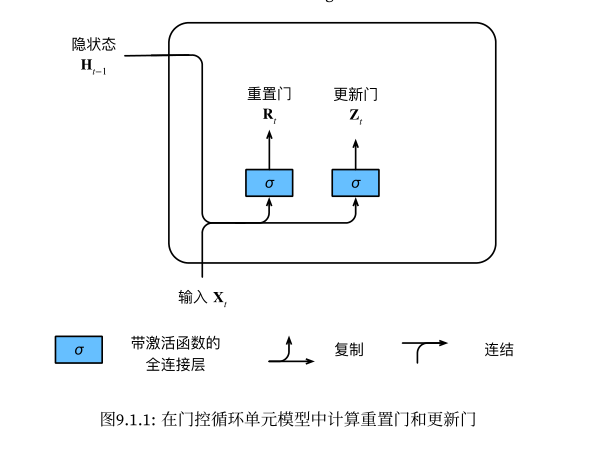
我们来看⼀下⻔控循环单元的数学表达。对于给定的时间步t，假设输⼊是⼀个⼩批量 X t ∈ R n×d （样本个
数n，输⼊个数d），上⼀个时间步的隐状态是 H t−1 ∈ R n×h （隐藏单元个数h）。那么，重置⻔R t ∈ R n×h 和更
新⻔Z t ∈ R n×h 的计算如下所⽰：
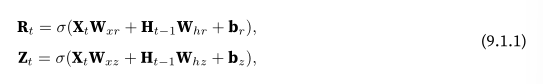
其中W xr ,W xz ∈ R d×h 和W hr ,W hz ∈ R h×h 是权重参数，b r ,b z ∈ R 1×h 是偏置参数。请注意，在求和过程中
会触发⼴播机制（请参阅 2.1.3节）。我们使⽤sigmoid函数（如 4.1节中介绍的）将输⼊值转换到区间(0,1)。

#### 候选隐状态
接下来，让我们将重置⻔R t 与(8.4.5)中的常规隐状态更新机制集成，得到在时间步t的候选隐状态（candidate
hidden state） ˜ H t ∈ R n×h 。
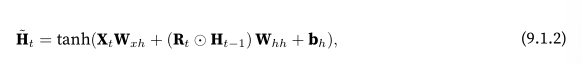
其中W xh ∈ R d×h 和W hh ∈ R h×h 是权重参数，b h ∈ R 1×h 是偏置项，符号⊙是Hadamard积（按元素乘积）运
算符。在这⾥，我们使⽤tanh⾮线性激活函数来确保候选隐状态中的值保持在区间(−1,1)中。

与 (8.4.5)相⽐，(9.1.2)中的R t 和H t−1 的元素相乘可以减少以往状态的影响。每当重置⻔R t 中的项接近1时，我
们恢复⼀个如 (8.4.5)中的普通的循环神经⽹络。对于重置⻔R t 中所有接近0的项，候选隐状态是以X t 作为输
⼊的多层感知机的结果。因此，任何预先存在的隐状态都会被重置为默认值。

图9.1.2说明了应⽤重置⻔之后的计算流程。
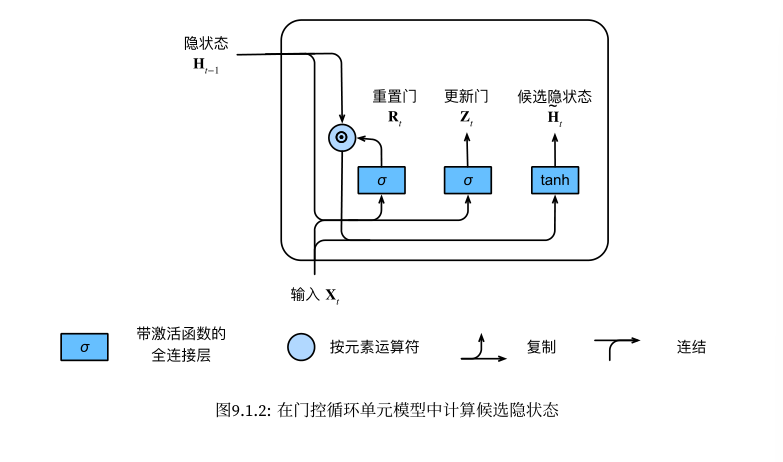
#### 隐状态
上述的计算结果只是候选隐状态，我们仍然需要结合更新⻔Z t 的效果。这⼀步确定新的隐状态H t ∈ R n×h 在
多⼤程度上来⾃旧的状态H t−1 和新的候选状态 ˜ H t 。更新⻔Z t 仅需要在 H t−1 和 ˜ H t 之间进⾏按元素的凸组合就
可以实现这个⽬标。这就得出了⻔控循环单元的最终更新公式：
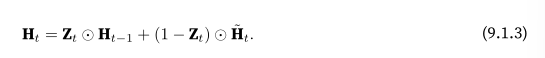
每当更新⻔Z t 接近1时，模型就倾向只保留旧状态。此时，来⾃X t 的信息基本上被忽略，从⽽有效地跳过了依
赖链条中的时间步t。相反，当Z t 接近0时，新的隐状态H t 就会接近候选隐状态 ˜ H t 。这些设计可以帮助我们处
理循环神经⽹络中的梯度消失问题，并更好地捕获时间步距离很⻓的序列的依赖关系。例如，如果整个⼦序
列的所有时间步的更新⻔都接近于1，则⽆论序列的⻓度如何，在序列起始时间步的旧隐状态都将很容易保
留并传递到序列结束。

图9.1.3说明了更新⻔起作⽤后的计算流。
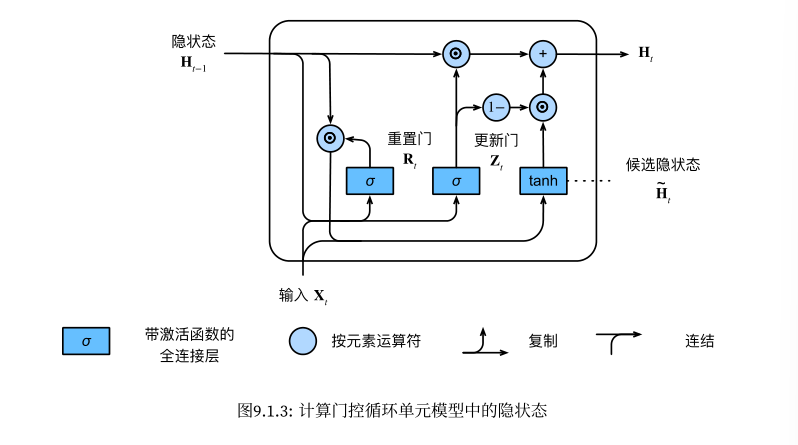
总之，⻔控循环单元具有以下两个显著特征：

    • 重置⻔有助于捕获序列中的短期依赖关系；
    • 更新⻔有助于捕获序列中的⻓期依赖关系。


### 从零开始实现

为了更好地理解⻔控循环单元模型，我们从零开始实现它。⾸先，我们读取 8.5节中使⽤的时间机器数据集：

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

#### 初始化模型参数

下⼀步是初始化模型参数。我们从标准差为0.01的⾼斯分布中提取权重，并将偏置项设为0，超参
数num_hiddens定义隐藏单元的数量，实例化与更新⻔、重置⻔、候选隐状态和输出层相关的所有权重和
偏置。

In [1]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in parmas:
        param.requires_grad_(True)
    return params

#### 定义模型
现在我们将定义隐状态的初始化函数init_gru_state。与 8.5节中定义的init_rnn_state函数⼀样，此函数
返回⼀个形状为（批量⼤⼩，隐藏单元个数）的张量，张量的值全部为零。

In [2]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备定义⻔控循环单元模型，模型的架构与基本的循环神经⽹络单元是相同的，只是权重更新公式
更为复杂。

In [3]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

#### 训练与预测
训练和预测的⼯作⽅式与 8.5节完全相同。训练结束后，我们分别打印输出训练集的困惑度，以及前缀“time
traveler”和“traveler”的预测序列上的困惑度。

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(vocab_size, num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 简洁实现
⾼级API包含了前⽂介绍的所有配置细节，所以我们可以直接实例化⻔控循环单元模型。这段代码的运⾏速
度要快得多，因为它使⽤的是编译好的运算符⽽不是Python来处理之前阐述的许多细节。

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, vocab_size)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

⼩结

    • ⻔控循环神经⽹络可以更好地捕获时间步距离很⻓的序列上的依赖关系。
    • 重置⻔有助于捕获序列中的短期依赖关系。
    • 更新⻔有助于捕获序列中的⻓期依赖关系。
    • 重置⻔打开时，⻔控循环单元包含基本循环神经⽹络；更新⻔打开时，⻔控循环单元可以跳过⼦序列。